<a href="https://colab.research.google.com/github/jsanz/elastic_esql_lab/blob/main/01-download_and_ingest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare data

Run this notebook in Google Colaboratory if your Elastic Stack is available from the internet. Otherwise, download the notebook and run it from your computer.

https://colab.research.google.com/github/jsanz/foss4g_europe_lab/blob/main/01-download_and_ingest.ipynb

In [1]:
# Install the dependencies for this lab
!pip install -qU elasticsearch overturemaps geopandas matplotlib

# Data dir
WORK_DIR="./data"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 929.5/929.5 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 85.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.1/65.1 kB 3.8 MB/s eta 0:00:00


## Connect to the Elastic stack

### Connect to Elasticsearch

If running in Google Colab, get the Elastic cluster credentials from the session **Secrets**. Otherwise update the cell to use `os.getenv` to get details from environment variables, for example.

In [2]:
try:
    from google.colab import userdata
    from elasticsearch import Elasticsearch
    # Login details
    ES_URL=userdata.get('es_url_siglibre')
    KB_URL=userdata.get('kb_url_siglibre')
    ES_APIKEY=userdata.get('apikey_siglibre')
except ImportError:
    import os
    if os.environ.get('ES_URL') and os.environ.get('KB_URL'):
        # Local development
        ES_URL = os.environ.get('ES_URL', 'http://localhost:9200')
        KB_URL = os.environ.get('KB_URL', 'http://localhost:8000')
        ES_APIKEY = os.environ.get('ES_APIKEY', None)
    else:
        import getpass
        ES_URL = getpass.getpass(prompt='Enter the Elasticsearch URL: ')
        KB_URL = getpass.getpass(prompt='Enter the Kibana URL: ')
        ES_APIKEY = getpass.getpass(prompt='Enter the Elasticsearch API Key: ')

In [3]:
from elasticsearch import Elasticsearch

# Create the Elasticsearch lient and print some cluster details
client = Elasticsearch(hosts=[ES_URL], api_key=ES_APIKEY)

if client.ping():
  print(f"Connected to {ES_URL}")
  c_info = client.info()
  c_license = client.license.get()['license']
  is_serverless = c_info['version']['build_flavor'] == 'serverless'

  print(f"Elasticsearch URL: {ES_URL}")
  print(f"Cluster name: {c_info['name']}")
  print(f"Version: {c_info['version']['number'] if not is_serverless else 'serverless'}")
  print(f"License is {c_license.get('status')} and on **{c_license.get('type')}** until **{c_license.get('expiry_date', 'N/A')}**")
else:
  print("Connection failed")

Connected to https://siglibre2025.es.us-central1.gcp.cloud.es.io
Elasticsearch URL: https://siglibre2025.es.us-central1.gcp.cloud.es.io
Cluster name: instance-0000000004
Version: 9.1.3
License is active and on **enterprise** until **2028-02-29T23:59:59.999Z**


### Connect to Kibana

In [5]:
import requests
import json
from functools import partial

session = requests.Session()
kibana_headers = {
    "kbn-xsrf": "true",
    "Content-Type": "application/json",
    "Authorization": f"ApiKey {ES_APIKEY}"
    }

# Helper functions to just pass API paths and data
def kib_get(path):
    return session.get(f"{KB_URL}{path}", headers=kibana_headers)
def kib_put(path, data):
    return session.put(f"{KB_URL}{path}",
                       headers=kibana_headers,
                       data=json.dumps(data))
def kib_post(path, data):
    return session.post(f"{KB_URL}{path}",
                        headers=kibana_headers,
                        data=json.dumps(data))

In [6]:
# Check the status
print(f"Kibana URL: {KB_URL}")
k_status = kib_get("/api/status").json()
if 'status' in k_status:
    print(json.dumps(k_status['status']['overall'], indent=2))
else:
    print("Kibana is not available")

Kibana URL: https://siglibre2025.kb.us-central1.gcp.cloud.es.io
{
  "level": "available",
  "summary": "All services and plugins are available"
}


In [7]:
# Optional: change default space to Search type (simpler UI)
desired_solution = "es"

# Get the default space data
default_space = kib_get("/api/spaces/space/default").json()

if not is_serverless:
    # If a solution is not defined or the desired, change it
    solution = default_space.get("solution", False)
    if solution != desired_solution:
        payload = {
            "id": default_space["id"],
            "name": default_space["name"],
            "solution": desired_solution
        }

        # Modify the Space with the new solution
        r_space = kib_put("/api/spaces/space/default", data=payload)
        r_space_json = r_space.json()
        print(f"Space is now a '{r_space_json.get('solution')}' type")
    else:
        print("Space is already a search type")
else:
    print("Serverless projects can't set up Spaces solutions")

Space is already a search type


## Overturemaps Places

### Download the data

Get Overturemaps Foundation Points of Interest (`places` dataset) using thir python library.

[Library](https://github.com/OvertureMaps/overturemaps-py/tree/main) | [Documentation](https://docs.overturemaps.org/guides/places/)  | [Reference](https://docs.overturemaps.org/schema/reference/places/place/)

In [ ]:
%%time
import os
import io
import pandas as pd
import geopandas as gpd
from overturemaps import core

# Get different bounding boxes from http://bboxfinder.com
# or https://boundingbox.klokantech.com/
places = {
    "bosnia": { "bbox": [15.688477,41.873651,20.489502,45.278752]},
    "girona": {"bbox": [2.3381,41.7123,3.2801,42.2483]},
    "valencia": {"bbox": [-0.432243,39.419221,-0.296288,39.504306]}
}

# Create the data dir if not exists
if not os.path.exists(WORK_DIR):
    os.makedirs(WORK_DIR)

for key, value in places.items():
    places_path = os.path.join(WORK_DIR, f"places_{key}.parquet")
    # Only download if file does not exist
    if not os.path.isfile(path=places_path):

        # Download places (POI) from the Overturemaps parquet release
        # using the overture library
        print(f"Downloading data for {key}")
        gdf = core.geodataframe("place",bbox=value["bbox"])
        print(f"{len(gdf)} features downloaded into {places_path}")

        # Save the content into a file
        gdf.to_parquet(path=places_path)
    else:
        print(f"{places_path} already downloaded")

166644 features downloaded into ./data/places_bosnia.parquet
20899 features downloaded into ./data/places_girona.parquet
36193 features downloaded into ./data/places_valencia.parquet
CPU times: user 15.6 s, sys: 2.49 s, total: 18.1 s
Wall time: 21 s


In [ ]:
# Get the parquet files from disk as GeoDataFrames into a list
dataframes = []

for key in places.keys():
    places_path = os.path.join(WORK_DIR, f"places_{key}.parquet")
    places[key]["gdf"] = gpd.read_parquet(path=places_path)
    print(f"{len(places[key]['gdf'])} features loaded from {places_path}")


166644 features loaded from ./data/places_bosnia.parquet
20899 features loaded from ./data/places_girona.parquet
36193 features loaded from ./data/places_valencia.parquet


,0
id,284b4fcf-224a-438a-b665-9ca6f572d909
geometry,POINT (15.6921637 41.9091427)
bbox,"{'xmax': 15.69216537475586, 'xmin': 15.6921634..."
version,1
sources,"[{'between': None, 'confidence': 0.98792562183..."
names,"{'common': None, 'primary': 'Village Camping R..."
categories,"{'alternate': ['restaurant', 'accommodation'],..."
confidence,0.987926
websites,[http://www.rancho.it/]
socials,[https://www.facebook.com/48506552944]


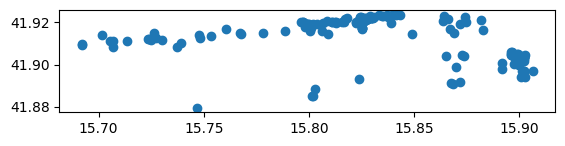

In [ ]:
# See the first row and some points on a map
gdf = list(places.items())[0][1]["gdf"]
# See the first row and some points on a map
gdf.head(200).plot()
gdf.iloc[0]

### Upload the Overturemaps datasets

In [ ]:
# Define an index template for places indices
index_shards = 1
index_replicas = 0 if ES_URL.startswith("http://elasticsearch") else 1

component_template_body = {
    "mappings": {
        "properties": {
            "id": {"type": "text"},
            "geometry": {"type": "geo_point"},
            "version": {"type": "integer"},
            "source": {"type": "keyword"},
            "confidence": {"type": "float"},
            "name": {"type": "text"},
            "category": {"type": "keyword"},
            "alt_categories": {"type": "keyword"},
            "websites": {"type": "text"},
            "socials": {"type": "text"},
            "emails": {"type": "text"},
            "phones": {"type": "text"},
            "brand": {"type": "keyword"},
            "addresses": {
                "properties": {
                    "country": {"type": "keyword"},
                    "freeform": {"type": "text"},
                    "locality": {"type": "keyword"},
                    "postcode": {"type": "keyword"},
                    "region": {"type": "keyword"},
                }
            },
            "updated": {"type": "date"}
        }
    }
}

# Self-hosted allow to set up shards and replica settings
if not is_serverless:
    component_template_body["settings"] = {
        "number_of_shards": index_shards,
        "number_of_replicas": index_replicas
    }

# Create a template that automatically configures indices named as places*
client.indices.put_index_template(
    name="overturemaps-places",
    index_patterns="places-*",
    template=component_template_body)

ObjectApiResponse({'acknowledged': True})

In [ ]:
# Generator funcion to yield documents to upload to ES
def generate_actions(gdf):
    for index, doc in gdf.iterrows():
        yield {
            "_index": index_name,
            "_id": doc["id"],
            "_source": {
                "id": doc["id"],
                "geometry": str(doc["geometry"]),
                "version": doc["version"],
                "source": [s.get("dataset",None) for s in doc.get("sources",[])],
                "name": doc.get("names").get("primary", None) if "names" in doc else None,
                "category": doc.get("categories").get("primary", None) if "categories" in doc else None,
                "alt_categories": doc.get("categories").get("alternate", []),
                "brand": doc.get("brand").get("primary",None) if doc.get("brand", None) is not None else None,
                "websites": doc.get("websites",[]),
                "socials": doc.get("socials",[]),
                "emails": doc.get("emails",[]),
                "phones": doc.get("phones",[]),
                "addresses": doc.get("addresses",[]),
                "updated": [s.get('update_time') for s in doc.get('sources')][0],
                "confidence": [s.get('confidence') for s in doc.get('sources')][0],
            }
        }

In [ ]:
%%time
from elasticsearch import helpers
import time

DELETE_INDEX=False

# Iterate over the geodataframes to create
# one index per parquet file
for key, value in places.items():
    index_name = f"places-{key}"
    print(f"Start processing {index_name}")

    # Remove the index if necessary
    if client.indices.exists(index=index_name):
        if DELETE_INDEX:
            print(f"Deleting previous index {index_name}")
            client.indices.delete(index=index_name)
        else:
            print("Index is present, skipping upload")

    if not client.indices.exists(index=index_name):
        # Create the index with the correct mappings and properties
        client.indices.create(index=index_name)

        # Perform the bulk ingestion
        print(f"Starting ingestion into {index_name}...")
        start_time = time.time()
        success_count, errors = helpers.bulk(
            client,
            generate_actions(value["gdf"]),
            stats_only=True
        )
        end_time = time.time()

        print(f"Bulk ingestion completed in {end_time - start_time:.2f} seconds.")
        print(f"Successfully indexed: {success_count} documents.")
        if errors:
            print(f"Errors encountered: {len(errors)}")
            # print("First few errors:", errors[:5]) # Uncomment to see actual errors

        # (Optional) Refresh the index to make documents searchable immediately
        # This is usually done for testing/development. For production, rely on refresh_interval.
        refresh = client.indices.refresh(index=index_name)
        if refresh.get("_shards",{}).get("successful",0) == 1:
            print("Index refresh successful")

        print("-----------------------------------")

Start processing places-bosnia
Starting ingestion into places-bosnia...
Bulk ingestion completed in 81.15 seconds.
Successfully indexed: 166644 documents.
-----------------------------------
Start processing places-girona
Starting ingestion into places-girona...
Bulk ingestion completed in 9.62 seconds.
Successfully indexed: 20899 documents.
-----------------------------------
Start processing places-valencia
Starting ingestion into places-valencia...
Bulk ingestion completed in 15.96 seconds.
Successfully indexed: 36193 documents.
-----------------------------------
CPU times: user 50.9 s, sys: 271 ms, total: 51.2 s
Wall time: 1min 49s


In [ ]:
# Create a Kibana data view for the places-* pattern
payload = {
    "data_view": {
        "name": "Overturemaps Places",
        "title": "places-*",
        "timeFieldName": "update_time"
  }
}
# Add the data view using the Kibana API
r_dataview = kib_post("/api/data_views/data_view", data=payload).json()

if 'data_view' in r_dataview:
    print("Data view created!")
else:
    print("Data view not created")
    print(f"Message: {r_dataview['message']}")

Data view created!


In [ ]:
# Verify ingestion by searching in places-*
print("Verifying document count in all places indices':")
try:
    count_response = client.count(index="places-*")
    print(f"Documents places-*: {count_response['count']}")
except Exception as e:
    print(f"Error verifying documents: {e}")


print("\nSearching for documents in places-* with names...")
try:
    response = client.search(
        index="places-*",
        query={"bool": {"filter": {"exists": {"field": "name"}}}},
        size=10
    )

    # Process the search results
    if response['hits']['total']['value'] > 0:
        for hit in response['hits']['hits']:
            print(f"[{hit['_index']}] {hit['_source']['name']} [{hit['_source']['category']}]")
    else:
        print("No documents found in the index.")

except Exception as e:
    print(f"Error during search: {e}")

Verifying document count in all places indices':
Documents places-*: 223736

Searching for documents in places-* with names...
[places-bosnia] 4coffee soul food [coffee_shop]
[places-bosnia] In The Palace - Rooms [hotel]
[places-bosnia] Tae kwon-do klub "Split" [community_services_non_profits]
[places-bosnia] Splash [cafe]
[places-bosnia] Tris Split [cafe]
[places-bosnia] Apartment Paradiso Split [hotel]
[places-bosnia] Benediktinski samostan sv. Eufemije [convents_and_monasteries]
[places-bosnia] Kamali [womens_clothing_store]
[places-bosnia] Pellegrini Luxury Rooms [hotel]
[places-bosnia] EVO RUKE [topic_concert_venue]


## Natural Earth Countries data

In [ ]:
# Download and uncompress the NaturalEarth countries dataset
from io import BytesIO
import zipfile

ne_countries_shp = "data/ne_10m_admin_0_countries.shp"

try:
    if not os.path.exists(ne_countries_shp):
        url = "https://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_0_countries.zip"
        extract_to = "data/"
        print(f"Downloading zip file from: {url}")
        response = requests.get(url, stream=True)
        response.raise_for_status()  # Raise an exception for bad status codes (4xx or 5xx)

        # Create a BytesIO object from the response content
        zip_file_in_memory = BytesIO(response.content)

        print(f"Extracting contents to: {os.path.abspath(extract_to)}")
        # Create the extraction directory if it doesn't exist
        os.makedirs(extract_to, exist_ok=True)

        with zipfile.ZipFile(zip_file_in_memory, 'r') as zf:
            zf.extractall(extract_to)
        print("Zip file successfully downloaded and uncompressed.")
    else:
        print("data/ne_10m_admin_0_countries.shp ready to use")
except requests.exceptions.RequestException as e:
    print(f"Error downloading the file: {e}")
except zipfile.BadZipFile:
    print("Error: The downloaded file is not a valid zip file.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


Extracting contents to: /content/data
Zip file successfully downloaded and uncompressed.


In [ ]:
gdf = gpd.GeoDataFrame.from_file(ne_countries_shp)

# Simplify the geometries before uploading
gdf['geometry'] = gdf['geometry'].simplify(0.0001, preserve_topology=True)

In [ ]:
# Select the columns to ingest as field mappings
component_template_body = {
    "mappings": {
        "properties": {
            "id": {"type": "text"},
            "geometry": {"type": "geo_shape"},
            "type": {"type": "keyword"},
            "name": {"type": "text"},
            "iso_a2": {"type": "keyword"},
            "iso_a3": {"type": "keyword"},
            "continent": {"type": "keyword"},
            "region_un": {"type": "keyword"},
            "subregion": {"type": "keyword"},
            "economy": {"type": "keyword"},
            "income_grp": {"type": "keyword"},
            "pop_est": {"type": "integer"},
            "gdp_md": {"type": "integer"},
        }
    }
}

# Self-hosted allow to set up shards and replica settings
if not is_serverless:
    component_template_body["settings"] = {
        "number_of_shards": 1,
        "number_of_replicas": 0,
        "index.mode": "lookup"
    }

# Create a template that automatically configures indices named as places*
client.indices.put_index_template(
    name="overturemaps-places",
    index_patterns="ne_countries",
    template=component_template_body)

ObjectApiResponse({'acknowledged': True})

In [ ]:
# Generator funcion to yield documents to upload to ES
def generate_actions(gdf):
    for index, doc in gdf.iterrows():
        yield {
            "_index": index_name,
            "_source": {
                "id": doc["WOE_ID_EH"],
                "geometry": str(doc["geometry"]),
                "type": doc["TYPE"],
                "name": doc["NAME"],
                "iso_a2": doc["ISO_A2_EH"],
                "iso_a3": doc["ISO_A3_EH"],
                "continent": doc["CONTINENT"],
                "region_un": doc["REGION_UN"],
                "subregion": doc["SUBREGION"],
                "economy": doc["ECONOMY"],
                "income_grp": doc["INCOME_GRP"],
                "pop_est": doc["POP_EST"],
                "gdp_md": doc["GDP_MD"],
            }
        }

In [ ]:
%%time
from elasticsearch import helpers
import time

DELETE_INDEX=False

index_name = "ne_countries"
print(f"Start processing {index_name}")

# Remove the index if necessary
if client.indices.exists(index=index_name):
    if DELETE_INDEX:
        print(f"Deleting previous index {index_name}")
        client.indices.delete(index=index_name)
    else:
        print("Index is present, skipping upload")

if not client.indices.exists(index=index_name):
    # Create the index with the correct mappings and properties
    client.indices.create(index=index_name)

    # Perform the bulk ingestion
    print(f"Starting ingestion into {index_name}...")
    start_time = time.time()
    success_count, errors = helpers.bulk(
        client,
        generate_actions(gdf),
        stats_only=True,
        chunk_size=50,
        raise_on_error=False
    )
    end_time = time.time()

    print(f"Bulk ingestion completed in {end_time - start_time:.2f} seconds.")
    print(f"Successfully indexed: {success_count} documents.")
    if errors:
        print(errors)
        # print(f"Errors encountered: {len(errors)}")
        # print("First few errors:", errors[:5]) # Uncomment to see actual errors

    # (Optional) Refresh the index to make documents searchable immediately
    # This is usually done for testing/development. For production, rely on refresh_interval.
    refresh = client.indices.refresh(index=index_name)
    if refresh.get("_shards",{}).get("successful",0) == 1:
        print("Index refresh successful")

    print("-----------------------------------")

Start processing ne_countries
Starting ingestion into ne_countries...
Bulk ingestion completed in 6.29 seconds.
Successfully indexed: 257 documents.
1
Index refresh successful
-----------------------------------
CPU times: user 450 ms, sys: 18 ms, total: 468 ms
Wall time: 6.63 s


In [ ]:
# Create a Kibana data view for the places-* pattern
payload = {
    "data_view": {
        "name": "NaturalEarth Countries",
        "title": index_name
  }
}
# Add the data view using the Kibana API
r_dataview = kib_post("/api/data_views/data_view", data=payload).json()

if 'data_view' in r_dataview:
    print("Data view created!")
else:
    print("Data view not created")
    print(f"Message: {r_dataview['message']}")

Data view created!


In [ ]:
# Verify ingestion by searching in places-*
print(f"\nVerifying document count:")
try:
    count_response = client.count(index=index_name)
    print(f"Documents places-*: {count_response['count']}")
except Exception as e:
    print(f"Error verifying documents: {e}")


print(f"\nSearching for countries of type Lease...")
try:
    response = client.search(
        index=index_name,
        query={"term":{"type":{"value": "Lease"}}},
        size=10
    )

    # Process the search results
    if response['hits']['total']['value'] > 0:
        for hit in response['hits']['hits']:
            print(f"[{hit['_index']}] {hit['_source']['name']} [{hit['_source']['name']}]")
    else:
        print("No documents found in the index.")

except Exception as e:
    print(f"Error during search: {e}")


Verifying document count:
Documents places-*: 257

Searching for countries of type Lease...
[ne_countries] USNB Guantanamo Bay [USNB Guantanamo Bay]
[ne_countries] Baikonur [Baikonur]


### Checking for a missing document

We indexed `257` document but our Natural Earth dataset has `258` document. What is missing? Why?

In [ ]:
# Let's get the countries in our index
es_names_docs=client.search(
    index=index_name,
    query={"match_all": {}},
    _source_includes=False,
    fields=["name"],
    size=1000
)
es_countries = set([hit['fields']['name'][0] for hit in es_names_docs["hits"]["hits"]])
print(f"There are {len(es_countries)} different countries in our ES index")


# And a set from the "WOE_ID_EH" in the DataFrame
gdf_countries = set(gdf["NAME"])
print(f"There are {len(gdf_countries)} different countries in the Natural Earth DataFrame")

There are 257 different countries in our ES index
There are 258 different countries in the Natural Earth DataFrame


In [ ]:
# Let's substract the sets to get the missing country
gdf_countries - es_countries

{'Antarctica'}

In [ ]:
# Antarctica was not indexed in our bulk process, let's try to index it manually
from elasticsearch.exceptions import BadRequestError

# Get the Antarctica row
antarctica = gdf[gdf['NAME'] == 'Antarctica'].copy()

# Try the classic buffer-zero fix
antarctica["geometry"] = antarctica["geometry"].buffer(0)
doc = antarctica.iloc[0]

# Try to manually index that geometry
try:
    client.index(
        index="ne_countries",
        document={"geometry": str(doc["geometry"]),"name": doc["NAME"]}
    )
except BadRequestError as e:
    print(json.dumps(e.info, indent=2))

{
  "error": {
    "root_cause": [
      {
        "type": "document_parsing_exception",
        "reason": "[1:13] failed to parse field [geometry] of type [geo_shape]"
      }
    ],
    "type": "document_parsing_exception",
    "reason": "[1:13] failed to parse field [geometry] of type [geo_shape]",
    "caused_by": {
      "type": "illegal_argument_exception",
      "reason": "Polygon self-intersection at lat=-84.3517829528102 lon=-163.03271507289995"
    }
  },
  "status": 400
}


## Other snapshots

We maintain on a GCP bucket exposed as HTTP resources a number of snapshots that can be imported into any ES cluster in 8 or 9 series.

First add this snippet to the `elasticsearch.yml` configuration file:

```
repositories.url.allowed_urls:
        - "https://storage.googleapis.com/jsanz-bucket/*"
```

Then see the code on how to create a snapshot and execute a restore request

In [ ]:
snapshot_data = [
    {
      "repo_name": "ghcd",
      "base_path": "v8/ghcnd",
      "snapshots": [
          "ghcnd_daily_observations"
      ],
      "index_pattern": "ghcnd_daily_observations",
      "time_field": "date"
    },
    {
      "repo_name": "osm_data",
      "base_path": "v8/osm",
      "snapshots": [
          "osm_italy_centro",
          "osm_estonia",
          "osm_spain_valencia",
          "osm_usa_arizona",
          "osm_andorra"
      ],
      "index_pattern": "osm_*",
      "time_field": "timestamp"
    },
    {
      "repo_name": "geonames",
      "base_path": "v8/geospatial_demos",
      "snapshots": [
          "geonames"
      ],
      "index_pattern": "geonames",
      "time_field": "modification_date"
    }
]

In [ ]:
def restore_snapshot(snapshot_data):
  # Create the repository
  from elasticsearch.exceptions import NotFoundError
  repo_name = snapshot_data["repo_name"]

  # Check if the repo exists, create it if fails
  try:
    repo = client.snapshot.get_repository(name=repo_name)
  except NotFoundError:
    # Create the repo if not found
    print(f"Creating repository {repo_name}")
    client.snapshot.create_repository(name=repo_name,body={
      "type": "url",
      "settings": {
        "url": f"https://storage.googleapis.com/jsanz-bucket/{snapshot_data['base_path']}/"
      }
    })

  # Restore all snapshots stored in the repository
  for snapshot in snapshot_data['snapshots']:
    print(f"Restoring {snapshot} from {repo_name}")
    client.snapshot.restore(repository=repo_name, snapshot=snapshot, wait_for_completion=False)

In [ ]:
# Iterate over the repository entries
for entry in snapshot_data:
  # Check if index_pattern returns any data
  pattern = entry['index_pattern']
  count = client.count(index=pattern)

  # If no data is found, restore the snapshots
  if count.get('count',-1) == 0:
    print(f"Restoring snapshots from {entry['base_path']}")
    restore_snapshot(entry)
  # If count is not found in the API response, something went wrong
  elif count.get('count',-1) == -1:
    print(f"{pattern} count request went wrong, skipping.")
  # Data is already restored
  else:
    print(f"{pattern} has data, skipping.")

ghcnd_daily_observations has data, skipping.
osm_* has data, skipping.
geonames has data, skipping.


In [ ]:
for entry in snapshot_data:
  # Create a Kibana data view for index pattern
  payload = {
      "data_view": {
          "title": entry['index_pattern'],
          "timeFieldName": entry['time_field']
    }
  }
  # Add the data view using the Kibana API
  r_dataview = kib_post("/api/data_views/data_view", data=payload).json()

  if 'data_view' in r_dataview:
      print(f"Data view for [{entry['index_pattern']}] created!")
  else:
      print("Data view not created")
      print(f"Message: {r_dataview['message']}")

Data view for [ghcnd_daily_observations] created!
Data view for [osm_*] created!
Data view for [geonames] created!


In [ ]:
# Check how much data was stored
for entry in snapshot_data:
  count = client.count(index=entry['index_pattern'])
  print(f"{entry['index_pattern']}: {count.get('count',0):,}")

ghcnd_daily_observations: 29,075,053
osm_*: 99,589,937
geonames: 11,968,314


## Civio fires data

In [10]:
# Get the data
! mkdir -p data
! if [ ! -f ./data/fires-all.csv ]; then wget -qO ./data/fires-all.csv -nc https://data.civio.es/espanaenllamas/fires-map/fires-all.csv; fi
! if [ ! -f ./data/civio-causes.csv ]; then wget -qO ./data/civio-causes.csv -nc https://raw.githubusercontent.com/jsanz/elastic_esql_lab/refs/heads/main/data/civio-causes.csv; fi
! if [ ! -f ./data/civio-causes_desc.csv ]; then wget -qO ./data/civio-causes_desc.csv -nc https://raw.githubusercontent.com/jsanz/elastic_esql_lab/refs/heads/main/data/civio-causes_desc.csv; fi
! if [ ! -f ./data/civio-regions.csv ]; then wget -qO ./data/civio-regions.csv -nc https://raw.githubusercontent.com/jsanz/elastic_esql_lab/refs/heads/main/data/civio-regions.csv; fi

In [12]:
import pandas as pd
df = pd.read_csv('./data/fires-all.csv')
# read complementary CSV files
df_causes = pd.read_csv('./data/civio-causes.csv')
df_causes_desc = pd.read_csv('./data/civio-causes_desc.csv')
df_regions = pd.read_csv('./data/civio-regions.csv')

# Remove unnecessary comunidad column
df.drop("idcomunidad", axis=1, inplace=True)
df[df['lat'].notna()].iloc[0]

,39655
id,1980324276
superficie,20.0
fecha,1980-09-18
lat,42.376191
lng,-7.004868
latlng_explicit,0.0
idprovincia,32
idmunicipio,9
municipio,"BARCO DE VALDEORRAS, O"
causa,4


In [14]:
# Merge with regions and causes
df_merge = pd.merge(df, df_regions, on="idprovincia",how="left")
df_merge = pd.merge(df_merge, df_causes, on="causa",how="left")
df_merge = pd.merge(df_merge, df_causes_desc, on='causa_desc',how="left")
df_merge[df_merge['lat'].notna()].iloc[0]

,39655
id,1980324276
superficie,20.0
fecha,1980-09-18
lat,42.376191
lng,-7.004868
latlng_explicit,0.0
idprovincia,32
idmunicipio,9
municipio,"BARCO DE VALDEORRAS, O"
causa,4


In [15]:
# Define an index template for places indices
index_name = "civio-fires"
index_shards = 1
index_replicas = 0 if ES_URL.startswith("http://elasticsearch") else 1

component_template_body = {
  "mappings": {
    "properties": {
      "id": { "type": "text" },
      "fecha": { "type": "date" },
      "geometry": { "type": "geo_point" },
      "latlng_explicit": { "type": "boolean" },
      "superficie": { "type": "integer" },
      "causa": { "type": "keyword" },
      "causa_desc": { "type": "keyword" },
      "causa_es" : { "type": "keyword" },
      "causa_desc_en": { "type": "keyword" },
      "causa_supuesta": { "type": "boolean" },
      "comunidad": { "type": "keyword" },
      "provincia": { "type": "keyword" },
      "municipio": { "type": "keyword" },
      "muertos": { "type": "integer" },
      "heridos": { "type": "integer" },
      "medios": { "type": "integer" },
      "personal": { "type": "integer" },
      "gastos": { "type": "integer" },
      "perdidas": { "type": "integer" },
      "time_ctrl": { "type": "integer" },
      "time_ext": { "type": "integer" }
    }
  }
}

# Self-hosted allow to set up shards and replica settings
if not is_serverless:
    component_template_body["settings"] = {
        "number_of_shards": index_shards,
        "number_of_replicas": index_replicas
    }

# Create a template that automatically configures indices named as places*
client.indices.put_index_template(
    name=index_name,
    index_patterns=index_name,
    template=component_template_body)

ObjectApiResponse({'acknowledged': True})

In [16]:
# Generator funcion to yield documents to upload to ES
import math
import json

def generate_geometry(doc):
    if math.isnan(doc["lat"]) or math.isnan(doc["lng"]):
        return None
    else:
        return [round(doc["lng"],7),round(doc["lat"],7)]

def get_none_if_nan(value):
    if type(value) is str:
        return value
    else:
        return None if math.isnan(value) else value

def generate_actions(df):
    for index, doc in df.iterrows():
        yield {
            "_index": index_name,
            "_id": doc["id"],
            "_source": {
                "id": doc["id"],
                "geometry": generate_geometry(doc),
                "fecha": doc["fecha"],
                "latlng_explicit": not math.isnan(doc["latlng_explicit"]),
                "superficie": doc["superficie"],
                "causa": get_none_if_nan(doc["causa_en"]),
                "causa_desc": get_none_if_nan(doc["causa_desc_en"]),
                "causa_es": get_none_if_nan(doc["causa_es"]),
                "causa_desc_es": get_none_if_nan(doc["causa_desc_es"]),
                "causa_supuesta": int(doc["causa_supuesta"]) == 1,
                "comunidad": doc["comunidad"],
                "provincia": doc["provincia"],
                "municipio": doc["municipio"],
                "muertos": doc["muertos"],
                "heridos": doc["heridos"],
                "medios": doc["medios"],
                "personal": doc["personal"],
                "gastos": doc["gastos"],
                "perdidas": doc["perdidas"],
                "time_ctrl": doc["time_ctrl"],
                "time_ext": doc["time_ext"],
            }
        }
for r in generate_actions(df_merge[:1]):
    print(json.dumps(r["_source"], indent=2))
print("---")
for r in generate_actions(df_merge[df_merge['lat'].notna()][:1]):
    print(json.dumps(r["_source"], indent=2))
for r in generate_actions(df_merge[df_merge['causa_desc_es'].notna()][:1]):
    print(json.dumps(r["_source"], indent=2))

{
  "id": 1968290001,
  "geometry": null,
  "fecha": "1968-01-01",
  "latlng_explicit": false,
  "superficie": 14.0,
  "causa": "Fire caused by accident or negligence",
  "causa_desc": null,
  "causa_es": "Fuego por accidente o negligencia",
  "causa_desc_es": null,
  "causa_supuesta": true,
  "comunidad": "Andaluc\u00eda",
  "provincia": "M\u00e1laga",
  "municipio": "INDETERMINADO",
  "muertos": 0,
  "heridos": 0,
  "medios": 0,
  "personal": 0,
  "gastos": 0,
  "perdidas": 0,
  "time_ctrl": 0,
  "time_ext": 360
}
---
{
  "id": 1980324276,
  "geometry": [
    -7.0048679,
    42.3761908
  ],
  "fecha": "1980-09-18",
  "latlng_explicit": true,
  "superficie": 20.0,
  "causa": "Intentional fire",
  "causa_desc": null,
  "causa_es": "Fuego intencionado",
  "causa_desc_es": null,
  "causa_supuesta": true,
  "comunidad": "Galicia",
  "provincia": "Ourense",
  "municipio": "BARCO DE VALDEORRAS, O",
  "muertos": 0,
  "heridos": 0,
  "medios": 0,
  "personal": 12,
  "gastos": 0,
  "perdidas":

In [17]:
%%time
from elasticsearch import helpers
import time

DELETE_INDEX=False

print(f"Start processing {index_name}")

# Remove the index if necessary
if client.indices.exists(index=index_name):
    if DELETE_INDEX:
        print(f"Deleting previous index {index_name}")
        client.indices.delete(index=index_name)
    else:
        print("Index is present, skipping upload")

if not client.indices.exists(index=index_name):
    # Create the index with the correct mappings and properties
    client.indices.create(index=index_name)

    try:
        # Perform the bulk ingestion
        print(f"Starting ingestion into {index_name}...")
        start_time = time.time()
        success_count, errors = helpers.bulk(
            client,
            generate_actions(df_merge),
            stats_only=True
        )
        end_time = time.time()

        print(f"Bulk ingestion completed in {end_time - start_time:.2f} seconds.")
        print(f"Successfully indexed: {success_count} documents.")
        if errors:
            print(f"Errors encountered: {len(errors)}")
            print("First few errors:", errors[:5]) # Uncomment to see actual errors

        # (Optional) Refresh the index to make documents searchable immediately
        # This is usually done for testing/development. For production, rely on refresh_interval.
        refresh = client.indices.refresh(index=index_name)
        if refresh.get("_shards",{}).get("successful",0) == 1:
            print("Index refresh successful")
    except helpers.BulkIndexError as e:
        from pprint import pprint
        print(pprint(e.errors[0]))

Start processing civio-fires
Index is present, skipping upload
CPU times: user 10.1 ms, sys: 2 µs, total: 10.1 ms
Wall time: 85.6 ms


In [18]:
# Create a Kibana data view
payload = {
    "data_view": {
        "name": index_name,
        "title": index_name,
        "timeFieldName": "fecha"
  }
}
# Add the data view using the Kibana API
r_dataview = kib_post("/api/data_views/data_view", data=payload).json()

if 'data_view' in r_dataview:
    print("Data view created!")
else:
    print("Data view not created")
    print(f"Message: {r_dataview['message']}")

Data view not created
Message: Duplicate data view: civio-fires


In [19]:
# Verify ingestion by searching in the index
print("Verifying document count:")
try:
    count_response = client.count(index=index_name)
    print(f"Documents places-*: {count_response['count']}")
except Exception as e:
    print(f"Error verifying documents: {e}")


print("\nSearching for documents")
try:
    response = client.search(
        index=index_name,
        query={"bool": {"filter": {"exists": {"field": "geometry"}}}},
        size=3
    )

    # Process the search results
    if response['hits']['total']['value'] > 0:
        for hit in response['hits']['hits']:
            print(json.dumps(hit['_source'], indent=2))
    else:
        print("No documents found in the index.")

except Exception as e:
    print(f"Error during search: {e}")

Verifying document count:
Documents places-*: 292181

Searching for documents
{
  "id": 1985275004,
  "geometry": [
    -7.4397402,
    42.5531536
  ],
  "fecha": "1985-10-03",
  "latlng_explicit": true,
  "superficie": 112.0,
  "causa": "Intentional fire",
  "causa_desc": null,
  "causa_es": "Fuego intencionado",
  "causa_desc_es": null,
  "causa_supuesta": true,
  "comunidad": "Galicia",
  "provincia": "Lugo",
  "municipio": "MONFORTE DE LEMOS",
  "muertos": 0,
  "heridos": 0,
  "medios": 2,
  "personal": 32,
  "gastos": 0,
  "perdidas": 2,
  "time_ctrl": 0,
  "time_ext": 420
}
{
  "id": 1985277859,
  "geometry": [
    -7.1736219,
    42.7798126
  ],
  "fecha": "1985-10-03",
  "latlng_explicit": true,
  "superficie": 9.0,
  "causa": "Intentional fire",
  "causa_desc": null,
  "causa_es": "Fuego intencionado",
  "causa_desc_es": null,
  "causa_supuesta": true,
  "comunidad": "Galicia",
  "provincia": "Lugo",
  "municipio": "NOGAIS, AS",
  "muertos": 0,
  "heridos": 0,
  "medios": 0,
 